<a href="https://colab.research.google.com/github/yankikalfa/MGTF-405-Business-Forecasting/blob/main/Forecast_Combination.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import Lasso
import itertools
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from google.colab import drive
drive.mount('/content/drive')

plt.rc("figure", figsize=(16, 8))
plt.rc("font", size=14)

Mounted at /content/drive


In [2]:
df = pd.read_excel("/content/drive/MyDrive/MGTF 405/PredictorData2021.xlsx",0)
df['excess_returns'] = df['CRSP_SPvw'] -df['Rfree'] 
df.drop(['Index','CRSP_SPvw','Rfree','csp','CRSP_SPvwx'], axis=1, inplace=True)


/usr/local/lib/python3.7/dist-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


In [3]:
X = df.loc[515:df.shape[0]-2, ~df.columns.isin(['excess_returns','yyyymm'])].reset_index(drop=True)
Y = df.loc[516:,'excess_returns'].reset_index(drop=True)


In [4]:
#### create combination of features
input_columns = [i for i in X.columns]
for i in range(2,len(X.columns)+1):
    a = list(itertools.combinations(X.columns,i))
    input_columns = input_columns + a
    


In [5]:
def forecast_with_column_selections(X,Y,test_size,columns):
    """
    parameters:
    -----------
    X = DataFrame of independent variables
    Y = Series of dependent variable
    test_size = The number of data points to test on
    columns = The features to pass for training
    
    returns:
    --------
    rmse = Root mean square error of the test set
    predictions = an array of of predicted values 
    """
    
    
    predictions = []
    X_train = pd.DataFrame(X.loc[:len(X)-test_size-1,columns])
    Y_train = Y[:len(X)-test_size]
    
    for i in range(test_size):
        X_test = pd.DataFrame(X.loc[len(X)-test_size+i:len(X)-test_size+i,columns])
        Y_test = Y[len(X)-test_size+i]
        
        linear_reg = sm.OLS(Y_train, X_train)
        res = linear_reg.fit()
        pred_test = res.predict(X_test)
        predictions.append(pred_test.values[0])
        
        X_train = X_train.append(X_test).reset_index(drop=True)
        Y_train = Y_train.append(pd.Series(Y_test)).reset_index(drop=True)
        
    rmse = np.sqrt(mean_squared_error(Y[len(X)-test_size:], predictions))
    return rmse, np.array(predictions)

In [6]:
#### run the prediction for each combination of features
all_model_rmse = []
all_model_predictions =[]
for i in input_columns:
    RMSE, pred = forecast_with_column_selections(X,Y,24,i)
    all_model_rmse.append(RMSE)
    all_model_predictions.append(pred)
    

In [7]:
#### calculate weights for each model based on inverse RMSE of test set
inv_model_rmse = 1/np.array(all_model_rmse)
weight_for_each_model = inv_model_rmse/sum(inv_model_rmse)

In [8]:
#### multiply the output with the weights
weighted_output = []
for i in range(len(weight_for_each_model)):
    weighted_output.append(weight_for_each_model[i]*all_model_predictions[i])

In [9]:
#### create a final dataframe consisting of the weighted average score of all models
final = pd.DataFrame(weighted_output).sum(axis=0)

In [14]:
all_mod=pd.DataFrame(all_model_predictions).T

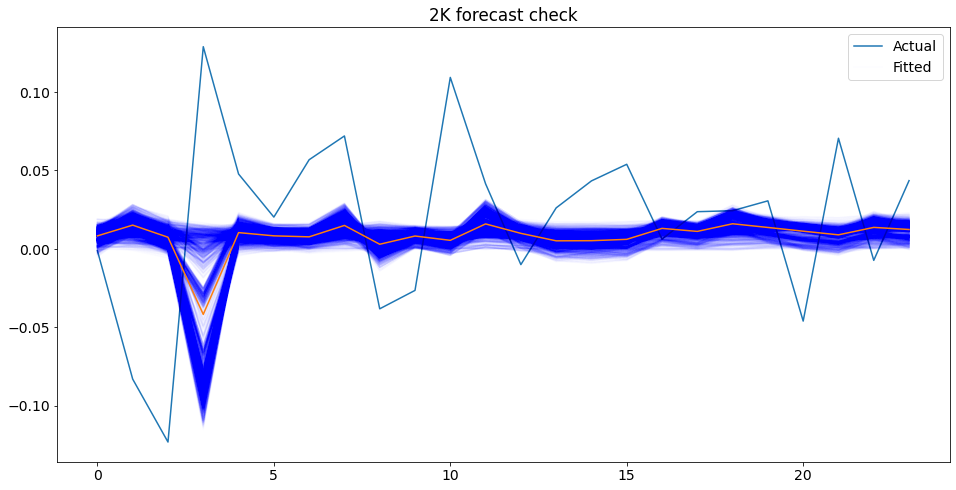

In [18]:
plt.plot([i for i in range(len(final))],Y[-24:])
plt.plot(all_mod,alpha=0.01,color='blue')
plt.plot([i for i in range(len(final))],final)
plt.legend(('Actual','Fitted'))
plt.title('2K forecast check')
plt.show()